# Homework6: Denoising Diffusion generative models

## Task 1: Theory (4pt)

### Problem 1: Faster sampling with DDPM (spaced diffusion) (1pt)

Sampling from DDPM is very slow. In the practical part of HW you will see that it took about 8 seconds to generate a batch of images with our diffusion model (even using a gpu).
While, as you might remember, it took less than a second using other generative models (VAE/GAN/NF).
This drawback can't be solved generally with using more gpus, since it requires iterative sampling.
There are several techniques to alleviate this drawback. In this task We are going to investigate one of them.

Assume we have already trained a model $p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta})$ to "reverse" a Markov chain of length $T$.

Let try to build inference process using subsequence of timesteps
$\{S_0 = 0, S_1, \ldots, S_{T'-1}, S_{T'} = T\}$, where $T' < T$.

Using this subsequence we have to do $T' (< T)$ inference steps instead of $T$. It could dramatically reduce inference time.

Diffusion models inference are essentially defined by
- schedule of variances $\{\beta_1, \ldots, \beta_T\}$
- reverse process:
$$
p(\mathbf{x}_{S_{t - 1}} | \mathbf{x}_{S_t}, \boldsymbol{\theta}) = \mathcal{N} \bigl(\mathbf{x}_{S_{t - 1}} | \boldsymbol{\mu}_{\boldsymbol{\theta}, S_t}(\mathbf{x}_{S_t}), \tilde{\beta}_{S_t}\bigr)
$$

Therefore, all you have to find is the variances for the new Markov chain: $\{\tilde{\beta}_{S_1}, \ldots, \tilde{\beta}_{S_{T'}}\}$.

**Task:** find the expression for $\tilde{\beta}_{S_t}$ (it should depend on $\alpha$).

```
your solution
```

$$
\mathbf{x}_t \sim q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})
$$
$$
\mathbf{x}_{S_t} \sim q(\mathbf{x}_{S_t} | \mathbf{x}_0) = \mathcal{N}(\sqrt{\bar{\tilde{\alpha}}_{S_t}} \mathbf{x}_0, (1 - \bar{\tilde{\alpha}}_{S_t}) \mathbf{I})
$$

$$
q(\mathbf{x}_t | \mathbf{x}_s) = \prod_{i = s+1}^tq(\mathbf{x}_i | \mathbf{x}_{i - 1})
$$
В прошлом дз найдена формула (используем то, что $\mu$ ищется через отношение соответствующих коэффициентов):
$$
q(\mathbf{x}_t | \mathbf{x}_s) = \mathcal{N}(\frac{\alpha_t}{\alpha_s} \mathbf{x}_s, \sigma_t^2\cdot \mathbf{I})
$$
То есть для нового процесса
$$
\tilde{\alpha}_{S_t} = \frac{\prod_{s=1}^{S_t} \alpha_s}{\prod_{s=1}^{S_{t-1}} \alpha_s} = \prod_{s=S_{t-1}+1}^{S_t} \alpha_s
$$
Зная, что
$$
\tilde{\beta}_{S_t} = 1 - \tilde{\alpha}_{S_t}
$$
Получаем
$$
\tilde{\beta}_{S_t} = 1 - \prod_{s=S_{t-1}+1}^{S_t} \alpha_s
$$

### Problem 2: Classifier guidance (1pt)

Consider the label distribution $p(\mathbf{y} | \mathbf{x})$. Assume that we are given the guidance scale $\gamma > 1$.

As we discussed at Lecture 12 the guidance scale sharpens the label distribution:
$$
    \hat{p}(\mathbf{y} | \mathbf{x}) \propto p(\mathbf{y} | \mathbf{x})^\gamma.
$$

In this case conditional distribution equals to
$$
     p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) = \frac{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y})}.
$$

Find the expression for $\nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta})$ in terms of the initial label distribution $p(\mathbf{y} | \mathbf{x})$.

You have to see that strictly speaking 
$$
     \nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta}) \neq \gamma \cdot \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta}).
$$

```
your solution
```

$$
    \hat{p}(\mathbf{y} | \mathbf{x}) = C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x})^\gamma
$$

$$
\int \hat{p}(\mathbf{y} | \mathbf{x}) dy = \int C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x})^\gamma dy
$$

$$
C(\mathbf{x}, \gamma) = \frac{1}{\int p(\mathbf{y} | \mathbf{x})^\gamma dy}
$$


$$
\nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta})=\nabla_{\mathbf{x}} \log \frac{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y})} = \nabla_{\mathbf{x}} (\log \hat{p}(\mathbf{y} | \mathbf{x}) + \log p(\mathbf{x} | \boldsymbol{\theta}) -\log \hat{p}(\mathbf{y})) = \nabla_{\mathbf{x}} \log (C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x})^\gamma) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta}) = \\ = \nabla_{\mathbf{x}} \log C(\mathbf{x}, \gamma) + \gamma \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta}) = - \nabla_{\mathbf{x}} \log \int p(\mathbf{y} | \mathbf{x})^\gamma dy + \gamma \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta})
$$

$$
\nabla_{\mathbf{x}} \log p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta})=
\frac{\nabla_{\mathbf{x}}p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta})}{p(\mathbf{x} | \mathbf{y}, \boldsymbol{\theta})}=\frac{\nabla_{\mathbf{x}}\frac{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y})}}{\frac{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y})}} =
 \frac{\nabla_{\mathbf{x}}\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{\hat{p}(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})} = 
 \frac{\nabla_{\mathbf{x}}C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x})^\gamma p(\mathbf{x} | \boldsymbol{\theta})}{C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x})^\gamma p(\mathbf{x} | \boldsymbol{\theta})}  = \\ = 
  \frac{(\nabla_{\mathbf{x}}C(\mathbf{x}, \gamma)) p(\mathbf{y} | \mathbf{x})^\gamma p(\mathbf{x} | \boldsymbol{\theta}) + C(\mathbf{x}, \gamma)(\gamma p(\mathbf{y} | \mathbf{x})^{\gamma-1} (\nabla_{\mathbf{x}}p(\mathbf{y} | \mathbf{x}))p(\mathbf{x} | \boldsymbol{\theta}) + p(\mathbf{y} | \mathbf{x})^\gamma \nabla_{\mathbf{x}} p(\mathbf{x} | \boldsymbol{\theta}))}{C(\mathbf{x}) p(\mathbf{y} | \mathbf{x})^\gamma p(\mathbf{x} | \boldsymbol{\theta})} = \\ =
   \frac{(\nabla_{\mathbf{x}}C(\mathbf{x}, \gamma)) p(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta}) + C(\mathbf{x}, \gamma)(\gamma  (\nabla_{\mathbf{x}}p(\mathbf{y} | \mathbf{x}))p(\mathbf{x} | \boldsymbol{\theta}) + p(\mathbf{y} | \mathbf{x}) \nabla_{\mathbf{x}} p(\mathbf{x} | \boldsymbol{\theta}))}{C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})} = \\ =
 \frac{(\nabla_{\mathbf{x}}C(\mathbf{x}, \gamma)) p(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})}{C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})} +  \gamma\frac{C(\mathbf{x}, \gamma)  (\nabla_{\mathbf{x}}p(\mathbf{y} | \mathbf{x}))p(\mathbf{x} | \boldsymbol{\theta})}{C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})} + \frac{C(\mathbf{x}, \gamma)p(\mathbf{y} | \mathbf{x}) \nabla_{\mathbf{x}} p(\mathbf{x} | \boldsymbol{\theta})}{C(\mathbf{x}, \gamma) p(\mathbf{y} | \mathbf{x}) p(\mathbf{x} | \boldsymbol{\theta})} = \\ =
 \frac{\nabla_{\mathbf{x}}C(\mathbf{x}, \gamma) }{C(\mathbf{x}, \gamma) } +  \gamma\frac{\nabla_{\mathbf{x}}p(\mathbf{y} | \mathbf{x})}{ p(\mathbf{y} | \mathbf{x})} + \frac{\nabla_{\mathbf{x}} p(\mathbf{x} | \boldsymbol{\theta})}{ p(\mathbf{x} | \boldsymbol{\theta})} = \nabla_{\mathbf{x}}\log C(\mathbf{x}, \gamma) + \gamma  \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta}) = - \nabla_{\mathbf{x}} \log \int p(\mathbf{y} | \mathbf{x})^\gamma dy + \gamma \nabla_{\mathbf{x}} \log p(\mathbf{y} | \mathbf{x}) + \nabla_{\mathbf{x}} \log p(\mathbf{x} | \boldsymbol{\theta})
$$

### Problem 3: KFP theorem (2pt)

In Lecture 13 we have faced with 2 different formulations of Kolmogorov-Fokker-Planck theorem.

1) We used the following KFP theorem when we discussed continuous-in-time NF:
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right).
$$

2) We used the following KFP theorem when we discussed SDEs:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] + \frac{1}{2} g^2(t) \frac{\partial^2 p(\mathbf{x}, t)}{\partial \mathbf{x}^2} \right)
$$

In this task your goal is to prove that the first formulation is a special case of the more general second formulation.

You have to use two facts:
1) Continuous-in-time NF use ODE (not SDE).
2) The derivation in the first formulation is total derivative (not partial).

```
your solution
```

Заметим, что при использовании ODE:
$$
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t)d t; g(t) = 0, \forall t
$$

$$\frac{d \mathbf{x}}{d t} = \mathbf{f}(\mathbf{x}, t)$$
 $g(t) = 0, \forall t$. То есть второе уравнение переписывается следующим образом:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] \right)
$$


$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial \mathbf{f}(\mathbf{x}, t)}{\partial \mathbf{x}} p(\mathbf{x}, t)- (\mathbf{f}(\mathbf{x}, t))^T \frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}}  \right)
$$
С другой стороны:
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right)
$$
$$
\frac{1}{p(\mathbf{x}(t), t)}\frac{d p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right)
$$
$$
\frac{1}{p(\mathbf{x}(t), t)}((\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}})^T\frac{\partial \mathbf{x}}{\partial t} + \frac{\partial p(\mathbf{x}, t)}{\partial t}) = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right)
$$

$$
\frac{1}{p(\mathbf{x}(t), t)}((\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}})^T\mathbf{f}(\mathbf{x}, t) + \frac{\partial p(\mathbf{x}, t)}{\partial t}) = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right)
$$

$$
\frac{1}{p(\mathbf{x}(t), t)}\frac{\partial p(\mathbf{x}, t)}{\partial t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right) - \frac{1}{p(\mathbf{x}(t), t)}(\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}})^T\mathbf{f}(\mathbf{x}, t)
$$

$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = - p(\mathbf{x}(t), t)\text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right) - (\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}})^T\mathbf{f}(\mathbf{x}, t)
$$
Используем, что след от числа равен этому же числу, линейность следа и $\text{tr}(AB) = \text{tr}(BA)$:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = - \text{tr} \left( p(\mathbf{x}(t), t)\frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right) - \text{tr}\left(\frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}}(\mathbf{f}(\mathbf{x}, t))^T\right) = \text{tr}\left(- \frac{\partial \mathbf{f}(\mathbf{x}, t)}{\partial \mathbf{x}} p(\mathbf{x}, t)- (\mathbf{f}(\mathbf{x}, t))^T \frac{\partial p(\mathbf{x}, t)}{\partial \mathbf{x}}  \right)
$$

In [2]:
!pip install --upgrade --no-cache-dir gdown

COMMIT_HASH = "b4df45506b5dc4cd055cb00facebc504fd57571a"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Cloning into 'dgm_utils'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 134 (delta 83), reused 89 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 26.47 KiB | 4.41 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/home/akkirr/lecture_tretyakovka/dgm_utils
Note: switching to 'b4df45506b5dc4cd055cb00facebc504fd57571a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config 

In [3]:
import dgm_utils

In [6]:
from tqdm import tqdm
from typing import List, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Task 2: DDPM for 2D data (5 pts)

In this part you have to implement your own diffusion model (DDPM) and apply it to 2D dataset.

Let's take a look at dataset samples.

In [7]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

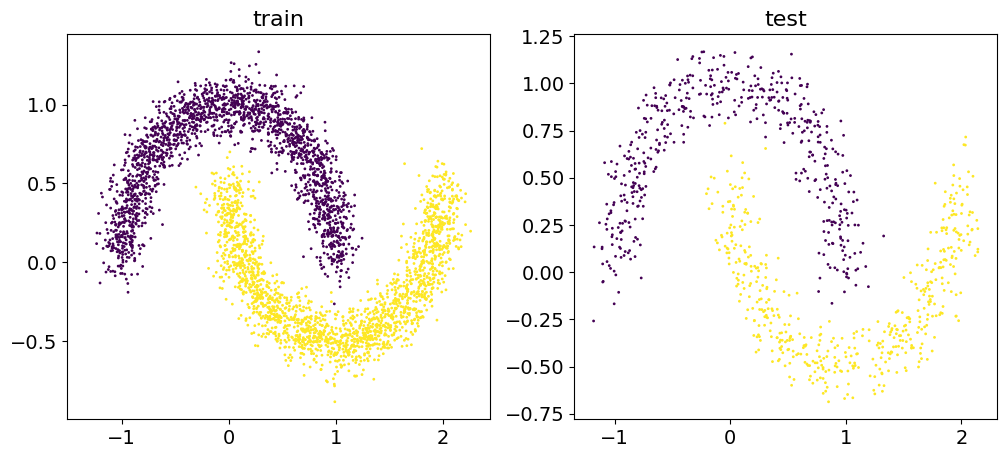

In [8]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
dgm_utils.visualize_2d_data(train_data, test_data, train_labels, test_labels)

Below you see the utility function, which broadcasts tensors. Look carefully at this code, we will use it in the majority of methods.

In [9]:
def _extract_into_tensor(arr, indices, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices to extract from arr.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    assert len(arr.shape) == 1
    res = arr.to(device=indices.device)[indices].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]


    return res.expand(broadcast_shape)

### Forward Diffusion

Let start with forward diffusion.

**Forward process** is defined as a posterior distribution $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

It is a Markov chain, which consequently adds gaussian noise to a given object $\mathbf{x}_0$.

At every step of this process the gaussian noise is added with different magnitude, which is determined with a schedule of variances $\{\beta_1, ... \beta_T\}$.
If this schedule is chosen properly and T goes to infinity (or is large enough), we will converge to pure noise $\mathcal{N}(0, I)$.

Markov chain is defined by:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) = \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}\mathbf{x}_{t - 1}, \beta_t \mathbf{I}), \quad q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

In order to get $\mathbf{x}_t$ we have to compute $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ iteratively.

Hopefully, due to the properties of the gaussian distribution we can do it more efficiently.

Let's denote
$\alpha_t = 1- \beta_t$ и $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Then
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$

Here we could get very useful expression
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

Now we will create base class for diffusion (we will use it as a python base class for forward and backward diffusions).

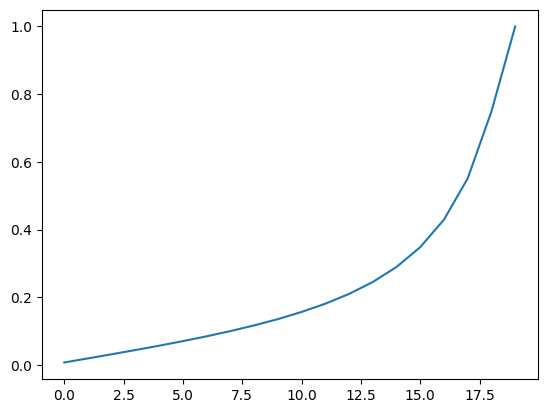

In [10]:
class BaseDiffusion:
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        self.betas = self._get_beta_schedule(num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=-1)
    
    @staticmethod
    def _get_beta_schedule(num_diffusion_timesteps, s=0.008):
        def f(t, T):
            return (np.cos((t / T + s) / (1 + s) * np.pi / 2)) ** 2

        alphas = []
        f0 = f(0, num_diffusion_timesteps)

        for t in range(num_diffusion_timesteps + 1):
            alphas.append(f(t, num_diffusion_timesteps) / f0)

        betas = []

        for t in range(1, num_diffusion_timesteps + 1):
            betas.append(min(1 - alphas[t] / alphas[t - 1], 0.999))

        return torch.from_numpy(np.array(betas)).double()


basediff = BaseDiffusion(num_timesteps=20)

plt.plot(basediff.betas.numpy())
plt.show()

We are ready to define forward diffusion process. It has 2 methods:
- to get mean and variance of the distribution $q(\mathbf{x}_t | \mathbf{x}_0)$,
- to get samples from this distribution.

In [11]:
class ForwardDiffusion(BaseDiffusion):
    def get_mean_variance(self, x0, t):
        # ====
        # your code
        # calculate mean and variance of the distribution q(x_t | x_0) (use equation (1))
        # use _extract_into_tensor() function to get tensors of the same shape as x0
        mean = _extract_into_tensor(torch.sqrt(self.alphas_cumprod), t, x0.shape)*x0
        variance = (1 - _extract_into_tensor(self.alphas_cumprod, t, x0.shape))
        # ====
        return mean, variance

    def get_samples(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        # ====
        # your code
        # sample from the distribution q(x_t | x_0) (use equation (2))
        mean, variance = self.get_mean_variance(x0, t)
        samples = mean + torch.sqrt(variance)*noise
        # ====
        return samples


def test_forward_diffusion():
    fdiff = ForwardDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    x0 = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    mean, variance = fdiff.get_mean_variance(x0=x0, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9944681)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.01103322)

    xt = fdiff.get_samples(x0=x0, t=t)
    assert list(xt.shape) == SHAPE

    noise = torch.ones(SHAPE)
    xt = fdiff.get_samples(x0=x0, t=t, noise=noise)
    assert np.allclose(xt.numpy(), np.ones(SHAPE) * 1.0995072)


test_forward_diffusion()

Let visualize the forward diffusion process. Here you have to see how the distribution of the real samples transforms to the gaussian noise.

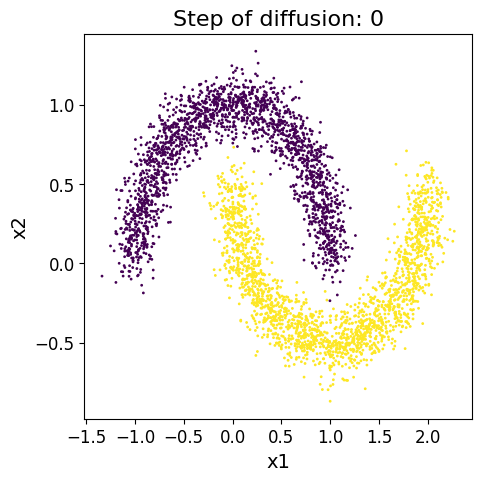

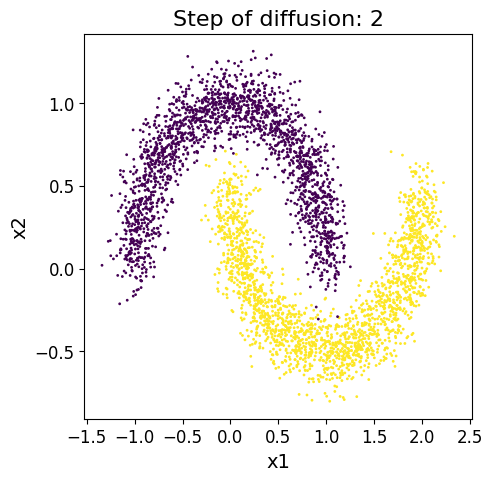

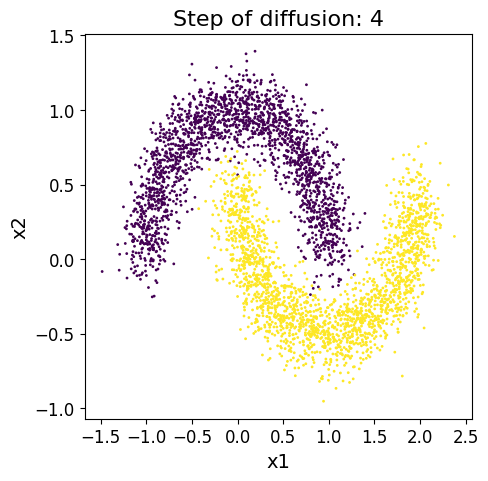

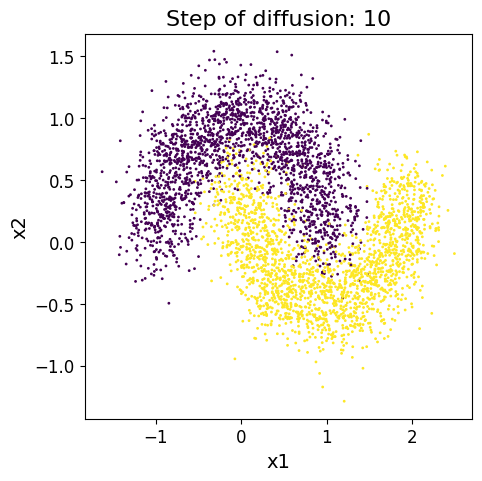

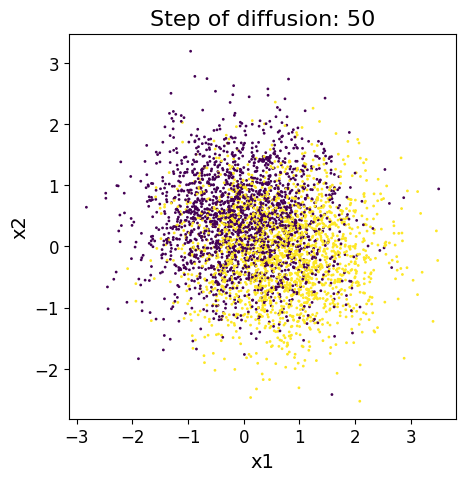

In [12]:
T = 100

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 2, 4, 10, 50]

plot_n_steps = len(timestamps)
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(train_data), t=torch.ones((train_data.shape[0], 1)).long() * t)
    dgm_utils.visualize_2d_samples(x, title=f"Step of diffusion: {t}", labels=train_labels)

### Reverse Diffusion

**Reverse process** consequently denoises pure gaussian noise $\mathcal{N}(0, \mathbf{I})$ until we do not get the object from the original distribution $\pi(\mathbf{x})$.

It is a probability model with latent variables
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
where
- latents $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T \}$ correspond to noised objects
- $\mathbf{x}_0$ is an object from the original distribution $\pi(\mathbf{x})$.

Joint distribution $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ is called reverse diffusion process, which is essentially a Markov chain of gaussian distributions $p(\mathbf{x}_t|\mathbf{x}_t, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta})=\mathcal{N}(0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t | \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)). \tag{3}
$$

In Lecture 11 we have derived ELBO for this model:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbb{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Here we use the following distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}( \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, where
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

(These scary formulas are not difficult to derive, follow the link to find details [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239)).

Now our goal is to define parameters $\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)$ of reverse diffusion.

#### Variance
Our first assumption is to set the variance $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \tilde{\beta}_t$. This is very native assumption

#### Mean
Here we will use the expression (2) to get $\mathbf{x}_0$ from $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

If we put this expression to the formula (4) we will get:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).
$$

So the idea here to parametrize the model mean in the same functional form:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \right).
$$

**Note:** our model will predict the noise which was applied to $\mathbf{x}_0$ to get $\mathbf{x}_t$.

In [13]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )

        # ====
        # your code
        # calculate variance of the distribution q(x_{t-1} | x_t, x_0) (use equation (5))
        self.variance = (1 - self.alphas_cumprod_prev)/(1 - self.alphas_cumprod)*self.betas
        # ====

        # ====
        # your code
        # calculate coefficients of mean of the distribution q(x_{t-1} | x_t, x_0) (use equation (4))
        # mean = x_coef * x_t + x0_coef * x_0
        self.xt_coef = torch.sqrt(self.alphas)*(1 - self.alphas_cumprod_prev)/(1 - self.alphas_cumprod)
        self.x0_coef = torch.sqrt(self.alphas_cumprod_prev)*self.betas/(1 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt, eps, t):
        # ====
        # your code
        # get x_0 (use equation (6))
        x0 = (xt - _extract_into_tensor(torch.sqrt(1 - self.alphas_cumprod), t, xt.shape)*eps)/_extract_into_tensor(
            torch.sqrt(self.alphas_cumprod), t, xt.shape)
        # ====
        return x0

    def get_mean_variance(self, xt, eps, t):
        # ====
        # your code
        # get mean and variance of the distribution q(x_{t-1} | x_t, x_0) (use equations (4) and (5))
        # use get_x0 method to get x_0
        x0 = self.get_x0(xt, eps, t)
        mean = _extract_into_tensor(self.xt_coef, t, xt.shape)*xt + _extract_into_tensor(
            self.x0_coef, t, xt.shape)*x0
        variance = _extract_into_tensor(self.variance, t, xt.shape)
        # ====
        return mean, variance

    def get_samples(self, xt, eps, t):
        # ====
        # your code
        # 1) get mean and variance of the distribution q(x_{t-1} | x_t, x_0)
        # 2) sample noise from the standard normal 
        # 3) get samples using reparametrization trick
        mean, variance = self.get_mean_variance(xt, eps, t)
        noise = torch.randn_like(xt, device=xt.device)
        sample = mean + noise*torch.sqrt(variance)
        # ====
        return sample.float()


def test_reverse_diffusion():
    rdiff = ReverseDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    xt = torch.ones(SHAPE)
    eps = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5

    x0 = rdiff.get_x0(xt=xt, eps=eps, t=t)
    assert list(x0.shape) == SHAPE
    assert np.allclose(x0.numpy(), np.ones(SHAPE) * 0.8999391)

    mean, variance = rdiff.get_mean_variance(xt=xt, eps=eps, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9723116)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.00222036)

    x = rdiff.get_samples(xt, eps, t)
    assert list(x.shape) == SHAPE


test_reverse_diffusion()

### Model

In this task we will use simple MLP model to parametrize distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t, \boldsymbol{\theta})$. It will be conditioned on the timestamps.

In [14]:
class ConditionalMLP(nn.Module):
    def __init__(self, input_dim: int, num_embeds: int, hidden_dim: int = 128):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(input_dim, self.hidden_dim)
        self.t_proj = nn.Embedding(num_embeds, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.SELU(),
            nn.Linear(self.hidden_dim, input_dim),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t):
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        x = x + t
        x = F.selu(x)
        return self.backbone(x)


def test_conditional_mlp():
    SHAPE = [2, 20]
    T = 100
    x = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    model = ConditionalMLP(input_dim=20, num_embeds=100)
    output = model(x, t)
    assert list(output.shape) == SHAPE


test_conditional_mlp()

### DDPM

Let return to the ELBO. The main part of it is:
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)
$$

In Lecture 11 we have got that
$$
    \mathcal{L}_t = \mathbb{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \|^2 \right].
$$

In practice this loss is simplified. Particilarly, we will omit coefficient of the norm and we will sample index $t$ at each training step.

Finally, we will train our model with the following objective:
$$
\text{loss} = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t)\|^2\bigg],
$$
where $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

The following class implements two methods:
- `loss` - to compute the loss at the training step;
- `sample` - to sample from the final model.

In [15]:
class DDPM(nn.Module):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps

        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps)
        self.model = model
        self.shape = None

    @property
    def device(self):
        return next(self.parameters()).device
        

    def sample(self, num_samples: int):
        assert self.shape is not None
        x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = torch.tensor([i] * num_samples, device=x.device)
            with torch.no_grad():
                # ====
                # your code
                # 1) get epsilon from the model
                # 2) sample from the reverse diffusion
                eps = self.model(x, t)
                x = self.reverse_diffusion.get_samples(x, eps, t)
                # ====
        return x

    def loss(self, x0):
        if self.shape is None:
            self.shape = list(x0.shape)[1:]
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)

        # ====
        # your code
        # 1) get x_t
        # 2) get epsilon from the model
        # 3) compute mse loss between epsilon and noise
        xt = self.forward_diffusion.get_samples(x0, t, noise)
        eps = self.model(xt, t)

        loss = torch.nn.functional.mse_loss(eps, noise)
        # ====
        return {"total_loss": loss}

### Training

Now we are ready to train our model.

Start of the training
Epoch: 0, loss: 0.7199082374572754
Epoch: 1, loss: 0.48215261846780777
Epoch: 2, loss: 0.5224786326289177
Epoch: 3, loss: 0.4651649370789528
Epoch: 4, loss: 0.473425529897213
Epoch: 5, loss: 0.45686083287000656
Epoch: 6, loss: 0.4450303167104721
Epoch: 7, loss: 0.45118488371372223
Epoch: 8, loss: 0.45596859604120255
Epoch: 9, loss: 0.43061093986034393
Epoch: 10, loss: 0.4235611855983734
Epoch: 11, loss: 0.42871933430433273
Epoch: 12, loss: 0.4363214001059532
Epoch: 13, loss: 0.42589935660362244
Epoch: 14, loss: 0.431127168238163
Epoch: 15, loss: 0.42915819585323334
Epoch: 16, loss: 0.42782624065876007
Epoch: 17, loss: 0.4272857755422592
Epoch: 18, loss: 0.4432363510131836
Epoch: 19, loss: 0.4319268763065338
Epoch: 20, loss: 0.4343087896704674
Epoch: 21, loss: 0.41416457295417786
Epoch: 22, loss: 0.43694107234477997
Epoch: 23, loss: 0.42467036098241806
Epoch: 24, loss: 0.41145890951156616
Epoch: 25, loss: 0.43884965032339096
Epoch: 26, loss: 0.4160243049263954
Epoc

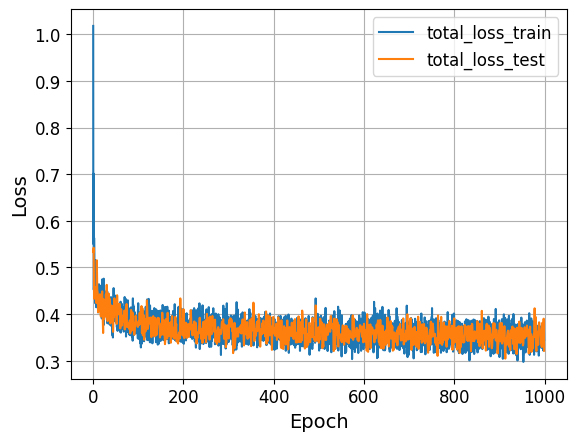

End of the training


In [16]:
T = 200 # you could change it
# ====
# your code
# choose these parameters
BATCH_SIZE = 1024
LR = 1e-3
EPOCHS = 1000
# ====

model = ConditionalMLP(input_dim=2, num_embeds=T, hidden_dim = 256)
ddpm = DDPM(num_timesteps=T, model=model)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# try your own optimizer/scheduler
#optimizer = torch.optim.AdamW(ddpm.parameters(), lr=LR, weight_decay=0.0001)
optimizer = torch.optim.AdamW(ddpm.parameters(), lr=LR, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999)

dgm_utils.train_model(
    model=ddpm,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=DEVICE,
    visualize_samples=False,
)

Now let's sample from our trained model.

100%|██████████| 200/200 [00:00<00:00, 564.13it/s]


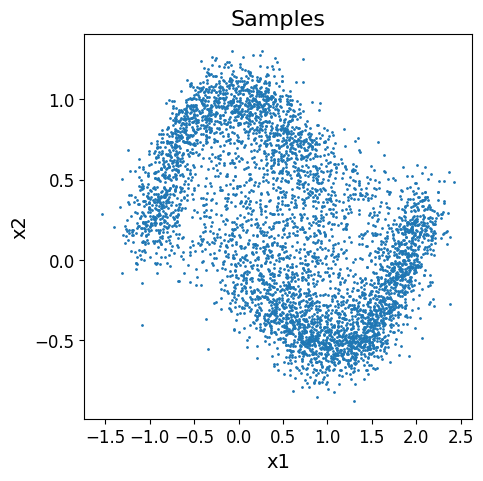

In [17]:
samples = ddpm.sample(num_samples=5000).cpu()

dgm_utils.visualize_2d_samples(samples, title="Samples")

Now let's see how denoising looks like (similarly to forward noising process).

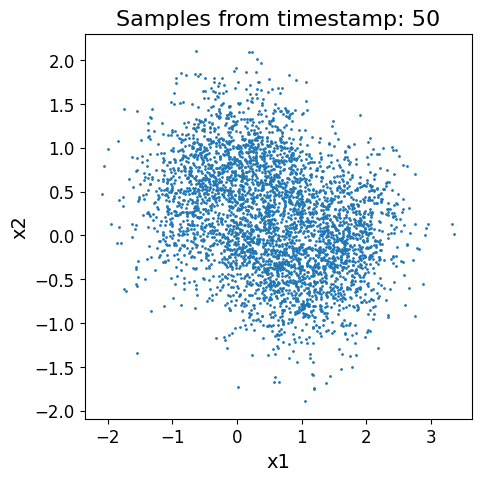

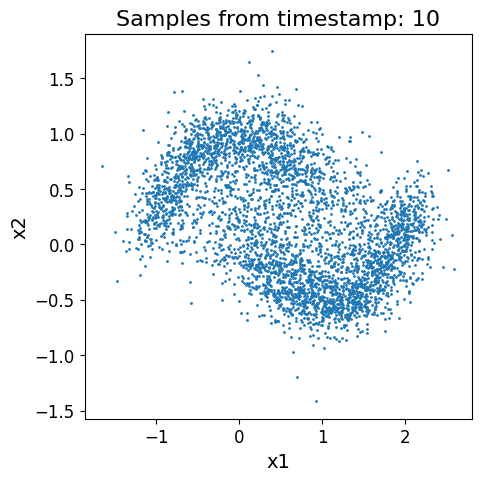

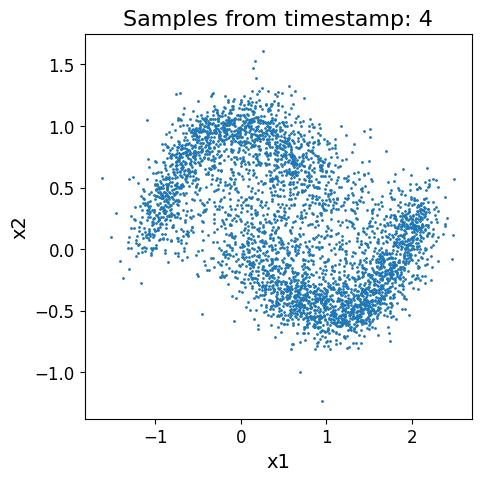

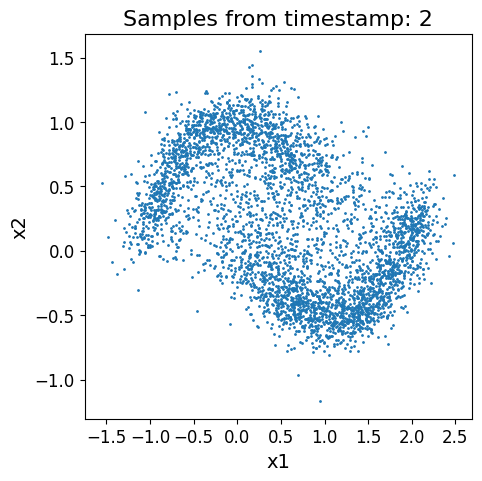

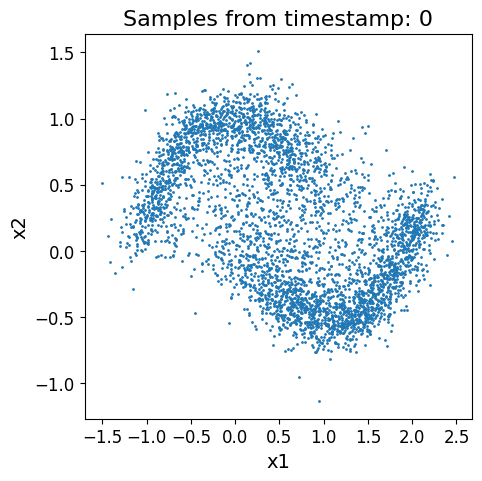

In [18]:
timestamps=[0, 2, 4, 10, 50]

x = torch.randn(train_data.shape[0], 2, requires_grad=False).to(ddpm.device)
for i in range(ddpm.num_timesteps - 1, -1, -1):
    t = torch.tensor(i, dtype=torch.long, requires_grad=False).expand(x.shape[0]).to(ddpm.device)
    with torch.no_grad():
        eps = ddpm.model(x, t)
        x = ddpm.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
    if i in reversed(timestamps):
        x_ = x.cpu()
        dgm_utils.visualize_2d_samples(x_, title=f"Samples from timestamp: {i}")

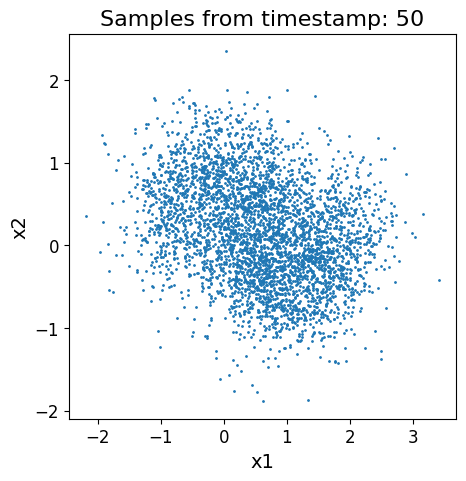

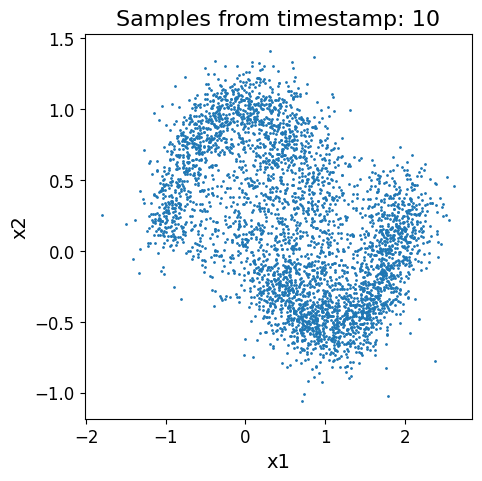

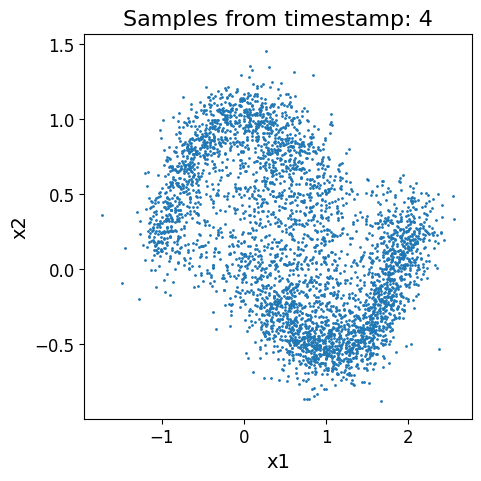

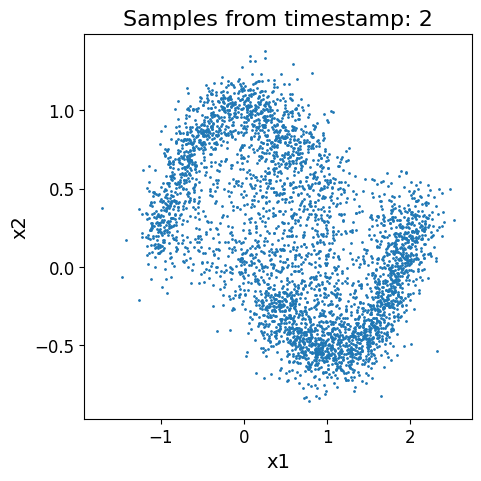

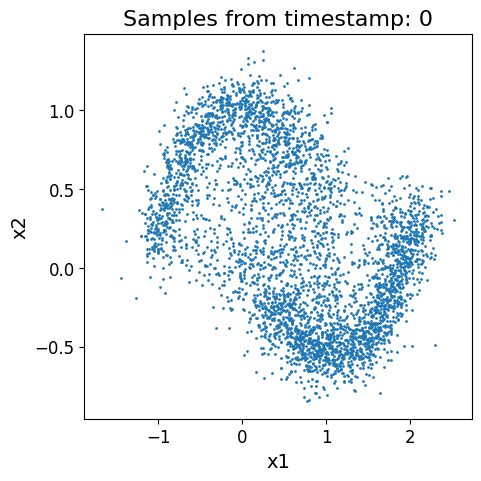

In [21]:
from pathlib import Path


timestamps=[0, 2, 4, 10, 50]

x = torch.randn(train_data.shape[0], 2, requires_grad=False).to(ddpm.device)
for i in range(ddpm.num_timesteps - 1, -1, -1):
    t = torch.tensor(i, dtype=torch.long, requires_grad=False).expand(x.shape[0]).to(ddpm.device)
    with torch.no_grad():
        eps = ddpm.model(x, t)
        x = ddpm.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
    if i in reversed(timestamps):
        x_ = x.cpu()
        dgm_utils.visualize_2d_samples(x_, title=f"Samples from timestamp: {i}")
    path = Path(f"vis_gb_hw6/images/{i:04d}.png")    
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.xlim(-1.75, 2.25)
    plt.ylim(-2, 2)
    plt.savefig(path)
    # plt.close()

0


NameError: name 'matcher' is not defined

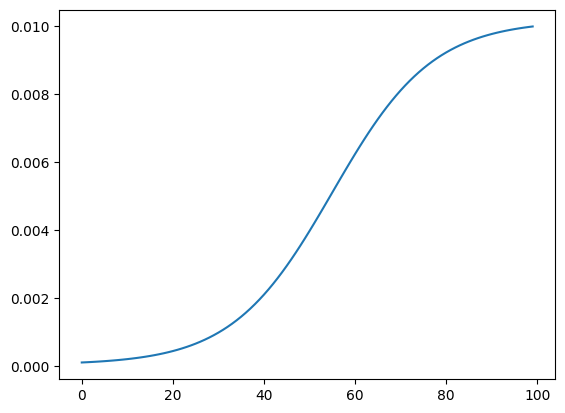

In [19]:
from IPython.display import clear_output


min_val = 0.0001
max_val = 0.01
vals = torch.sigmoid(torch.linspace(-5, 4, 100)).numpy()
vals = (vals - vals.min()) / (vals.max() - vals.min()) * (max_val - min_val) + min_val
plt.plot(vals)

for i, eta in enumerate(vals):
    print(i)
    torch.random.manual_seed(0)
    samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=eta).cpu()
    dgm_utils.visualize_2d_samples(samples, title="Samples")
    path = Path(f"vis1/images/{i:04d}.png")
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.xlim(-1.75, 2.25)
    plt.ylim(-2, 2)
    plt.savefig(path)
    clear_output()
clear_output()

## Task3: DDPM on MNIST (4pt)

Let apply our diffusion model to the MNIST dataset.

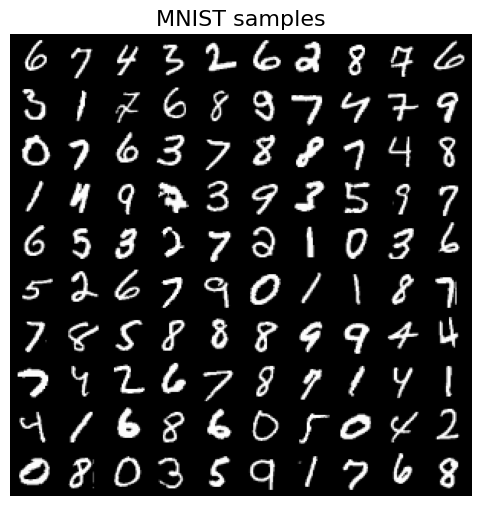

In [16]:
train_data, test_data = dgm_utils.load_dataset("mnist", flatten=False, binarize=False)

dgm_utils.visualize_images(train_data, "MNIST samples")

Let's take a look at the forward process for the MNIST images.

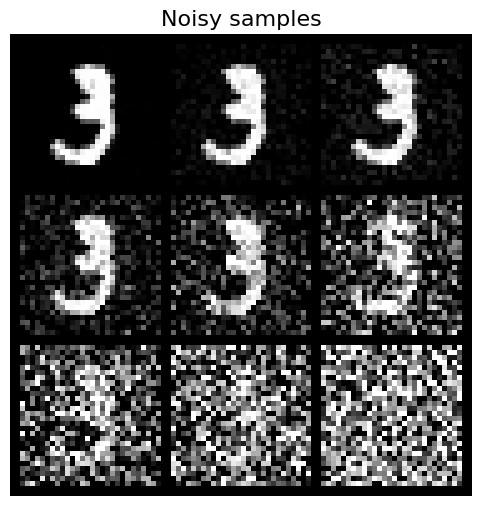

In [17]:
T = 1000

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 50, 100, 200, 300, 500, 600, 800, 999]

plot_n_steps = len(timestamps)
samples = []
x0 = train_data[10:11]
x0 = 2 * x0 - 1
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(x0), t=torch.ones((x0.shape[0], 1)).long() * t)
    samples.append(x.cpu().numpy())

samples = np.concatenate(samples)
samples = 0.5 * samples + 0.5
dgm_utils.show_samples(samples, title="Noisy samples")

The model is written for you. We will use conditioned ResNet architecture. But you could change it if you want.

In [18]:
class ConditionedResnetBlock(nn.Module):
    def __init__(self, dim: int, num_embeddings: int) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=1),
        )
        self.dim = dim
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=dim)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        time_embed = self.embedding(y).view(-1, self.dim, 1, 1)
        return x + self.block(x + time_embed)


class ConditionedSimpleResnet(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, n_filters: int, n_blocks: int, num_embeddings: int
    ) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.layers = nn.Sequential(*[ConditionedResnetBlock(n_filters, num_embeddings) for _ in range(n_blocks)])
        self.last_block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(n_filters, out_channels, kernel_size=3, padding=1)
        )
        self.n_filters = n_filters

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = self.first_block(x)
        for layer in self.layers:
            x = layer(x, t)
        x = self.last_block(x)
        return x


def test_conditioned_resnet():
    model = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=16, n_blocks=1, num_embeddings=2)
    x = torch.rand((1, 1, 28, 28))
    t = torch.zeros(size=(1,), dtype=torch.long)
    out1 = model(x, t)
    t = torch.ones(size=(1,), dtype=torch.long)
    out2 = model(x, t)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_conditioned_resnet()

Here we redefine two methods. Just to scale the data and clamp final samples.

In [19]:
class DDPMMNIST(DDPM):

    def sample(self, num_samples: int):
        x = super().sample(num_samples)
        return torch.clamp(0.5 * x + 0.5, -1.0, 1.0)

    def loss(self, x0):
        x0 = 2.0 * x0 - 1.0
        return super().loss(x0)

That is all. We are ready to train our model.

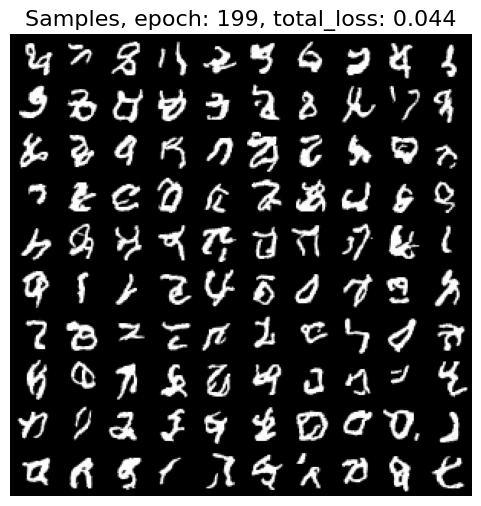

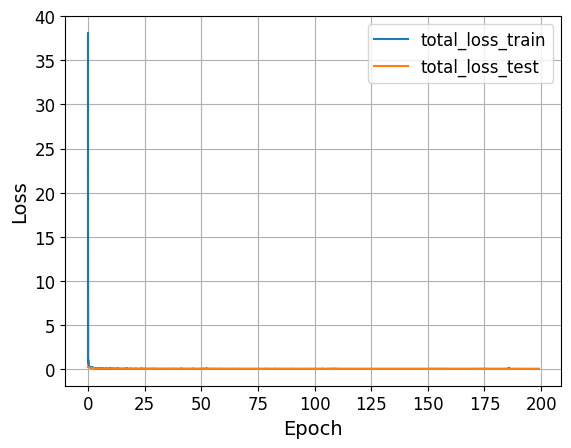

End of the training


In [20]:
T = 1000
# ====
# your code
# choose these parameters
BATCH_SIZE = 1024
LR = 1e-2
WEIGHT_DECAY = 1e-10
EPOCHS = 200
N_FILTERS = 64
N_BLOCKS = 8
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

model_mnist = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=N_FILTERS, n_blocks=N_BLOCKS, num_embeddings=T)
ddpm_mnist = DDPMMNIST(num_timesteps=T, model=model_mnist)

# try your own optimizer/scheduler
optimizer = torch.optim.AdamW(ddpm_mnist.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999)

dgm_utils.train_model(
    model=ddpm_mnist,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE,
)

100%|██████████| 1000/1000 [00:02<00:00, 367.45it/s]


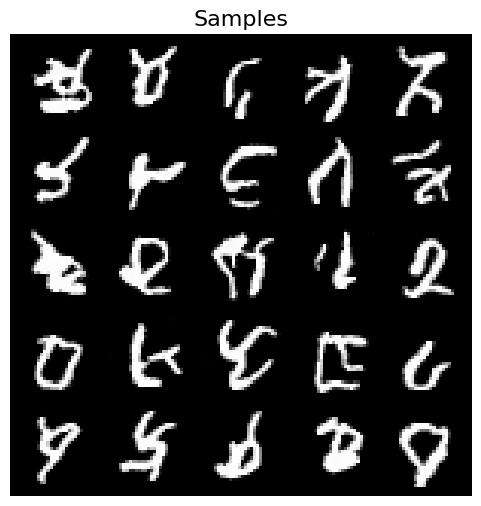

In [21]:
ddpm_mnist = ddpm_mnist.to(DEVICE)

samples = ddpm_mnist.sample(num_samples=25).cpu().numpy()

dgm_utils.show_samples(samples, title="Samples")

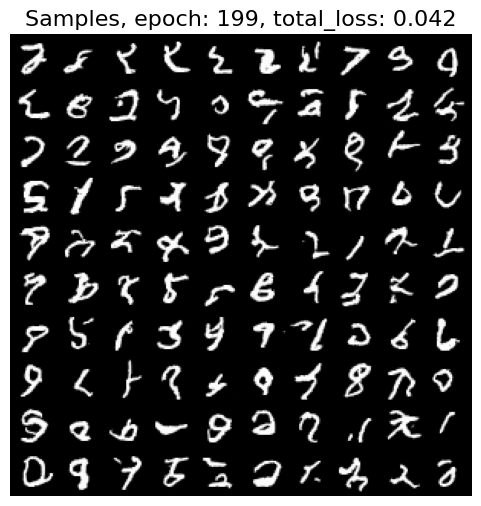

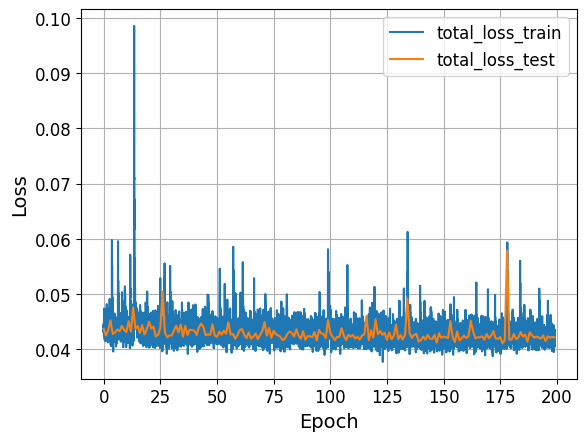

End of the training


In [23]:
dgm_utils.train_model(
    model=ddpm_mnist,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE,
)

Let's draw samples from the trained model.

100%|██████████| 1000/1000 [00:03<00:00, 279.71it/s]


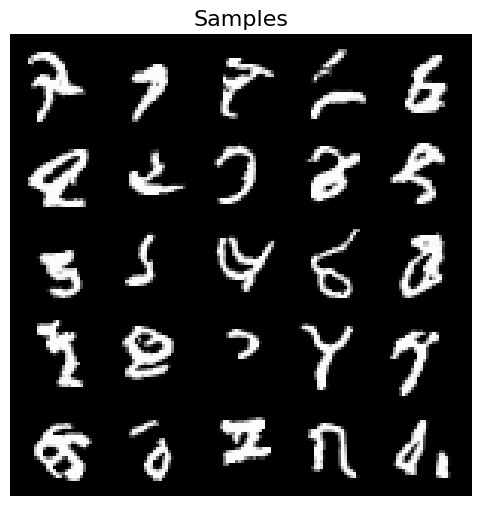

In [28]:
ddpm_mnist = ddpm_mnist.to(DEVICE)

samples = ddpm_mnist.sample(num_samples=25).cpu().numpy()

dgm_utils.show_samples(samples, title="Samples")